In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import Graph
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
def function1(input):
    return input + " this is from function1 "

In [3]:
def function2(input):
    return input + " and added the function2"

In [4]:
workflow1 = Graph()

workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

workflow1.add_edge("function1", "function2")

workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")

app1 = workflow1.compile()

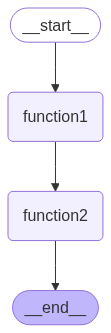

In [5]:
from IPython.display import Image, display

display(Image(app1.get_graph().draw_mermaid_png()))

In [6]:
app1.invoke("I am sam")

'I am sam this is from function1  and added the function2'

In [7]:
for event in app1.stream("This is sam"):
    for key, value in event.items():
        print(f"Node name: {key}")
        print(value)
        print("---")

Node name: function1
This is sam this is from function1 
---
Node name: function2
This is sam this is from function1  and added the function2
---


##### Scenario 2:

In [8]:
def function3():
    return " from Australia from function3"

In [9]:
def function1(input):
    return input + " this is from function1 "

In [10]:
def function2(input):
    output = function3()
    return input + output + " and added the function2"

In [11]:
workflow1 = Graph()

workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

workflow1.add_edge("function1", "function2")

workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")

app1 = workflow1.compile()

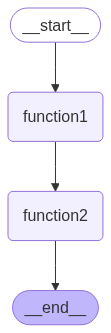

In [12]:
from IPython.display import Image, display

display(Image(app1.get_graph().draw_mermaid_png()))

In [13]:
app1.invoke("I am sam")

'I am sam this is from function1  from Australia from function3 and added the function2'

In [14]:
for event in app1.stream("This is sam"):
    for key, value in event.items():
        print(f"Node name: {key}")
        print(value)
        print("---")

Node name: function1
This is sam this is from function1 
---
Node name: function2
This is sam this is from function1  from Australia from function3 and added the function2
---


##### Scenario 3:

In [15]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")
llm.invoke("hi").content

'Hi! 👋 \n\nHow can I help you today?\n'

In [16]:
def chatbot(input):
    llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")
    return llm.invoke(input).content

In [17]:
def upperCase(input):
    return input.upper()

In [18]:
workflow2 = Graph()

workflow2.add_node("llm", chatbot)
workflow2.add_node("upper_case", upperCase)

workflow2.add_edge("llm", "upper_case")

workflow2.set_entry_point("llm")
workflow2.set_finish_point("upper_case")

app2 = workflow2.compile()

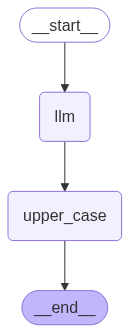

In [19]:
from IPython.display import display, Image

display(Image(app2.get_graph().draw_mermaid_png()))

In [20]:
app2.invoke("Who is the first prime minister of india?")

'THE FIRST PRIME MINISTER OF INDIA WAS **JAWAHARLAL NEHRU**. \n'

In [21]:
for output in app2.stream("Who is the first prime minister of india?"):
    for key, value in output.items():
        print(f"Node name: {key}")
        print(value)
        print("---")

Node name: llm
The first Prime Minister of India was **Jawaharlal Nehru**. 

---
Node name: upper_case
THE FIRST PRIME MINISTER OF INDIA WAS **JAWAHARLAL NEHRU**. 

---


##### Scenario 4:

In [22]:
def chatbot(input):
    llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")
    return llm.invoke(input).content

In [23]:
def countToken(input):
    tokens = input.split()
    return len(tokens)

In [24]:
workflow3 = Graph()

workflow3.add_node("llm", chatbot)
workflow3.add_node("token_count", countToken)

workflow3.add_edge("llm", "token_count")

workflow3.set_entry_point("llm")
workflow3.set_finish_point("token_count")

app3 = workflow3.compile()

In [25]:
app3.invoke("who is the current prime minister of india?")

9

In [26]:
for output in app3.stream("Who is the first prime minister of india?"):
    for key, value in output.items():
        print(f"Node name: {key}")
        print(value)
        print("---")

Node name: llm
The first Prime Minister of India was **Jawaharlal Nehru**. 

---
Node name: token_count
9
---


#### RAG on LangGraph

In [27]:
from langgraph.graph import StateGraph,  Graph
from langgraph.graph.message import MessagesState
from langchain_groq.chat_models import ChatGroq
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv
import os 

load_dotenv()

True

In [28]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [29]:
loader = DirectoryLoader("../data", glob="./*.txt", loader_cls=TextLoader)
docs = loader.load() 

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
documents = splitter.split_documents(docs)

db = Chroma.from_documents(documents, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 2})

retriever.invoke("what is the gdp of japan in 2022?")

[Document(metadata={'source': '..\\data\\japan.txt'}, page_content="Japan's last four year GDP:\n\nYear\tGDP\n2022\t$4,256.41B\n2021\t$5,034.62B\n2020\t$5,055.59B\n2019\t$5,117.99B"),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='Weaker exports, normally the engine for Japan\'s economy in the face of weak domestic demand, had helped trigger a 0.1% contraction in the final three months of last year after two previous quarters of shrinking GDP. Only an exceptionally strong performance in the early months of 2004 kept the year as a whole from showing a decline. The output figures brought a cautiously optimistic response from economic officials. "Overall I see a low risk of the economy falling into serious recession," said')]

In [30]:
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage, BaseMessage, AnyMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# class AgentState(TypedDict):
#     Annotated[list[AnyMessage], add_messages]

In [31]:
AgentState = {}

In [32]:
AgentState['messages'] = []

In [33]:
AgentState

{'messages': []}

In [34]:
def chatbot(AgentState):
    messages = AgentState['messages']
    question = messages[-1]
    
    complete_prompt = "You are a helpful assistant provide the answer based on the query: " + question
    
    response = llm.invoke(complete_prompt).content 
    AgentState['messages'].append(response)
    return AgentState  

In [35]:
def rag(AgentState):
    messages = AgentState['messages']
    question = messages[0]
    
    template = """ You are a helpful assistant. provide the answer based on provided
    context only {context}
    
    question: {query}
    """
    
    prompt = ChatPromptTemplate.from_template(template)
    
    chain = ({"context": retriever, "query": RunnablePassthrough()}
             | prompt 
             | llm 
             | StrOutputParser()
    )
    response = chain.invoke(question) 
    AgentState['messages'].append(response)
    return response
    

In [36]:
workflow4 = Graph()

workflow4.add_node("llm", chatbot)
workflow4.add_node("RAG", rag)

workflow4.add_edge("llm", "RAG")

workflow4.set_entry_point("llm")
workflow4.set_finish_point("RAG")

app4 = workflow4.compile()

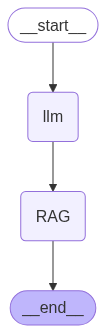

In [37]:
from IPython.display import display, Image

display(Image(app4.get_graph().draw_mermaid_png()))

In [38]:
app4.invoke({"messages": ["what is the gdp of japan in 2022?"]})

'$4,256.41B \n'

In [39]:
input = {"messages": ["what is the gdp of japan in 2022?"]}
for events in app4.stream(input):
    for key, value in events.items():
        print(f"Node: {key}")
        print(value)
        print("=====")

Node: llm
{'messages': ['what is the gdp of japan in 2022?', 'I do not have access to real-time information, including economic data like GDP. \n\nTo find the GDP of Japan in 2022, I recommend checking a reliable source such as:\n\n* **The World Bank:** https://data.worldbank.org/\n* **The International Monetary Fund (IMF):** https://www.imf.org/en/Data\n* **The Bank of Japan:** https://www.boj.or.jp/en/ \n* **Trading Economics:** https://tradingeconomics.com/ \n\n\nThese sources provide up-to-date and accurate economic data for various countries. \n']}
=====
Node: RAG
$4,256.41B 

=====


##### Adding conditional edges: 

In [40]:
import os 
from dotenv import load_dotenv
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, BaseMessage
from typing import TypedDict, Annotated, Sequence

In [41]:
groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="gemma2-9b-it")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [42]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [43]:
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="Selected Topic name")
    Reasoning: str = Field(description="Reason behind topic selection")

In [44]:
def function1(AgentState):
    print("<- Agent call ->")
    messages = AgentState['messages']
    question = messages[0]
    
    parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
    
    template = """ 
    You are an helpful assistant, based on user query provide the category ["Japan", "Not Japan"].
    Make sure the answer should be on those category. 
    question: {question}
    \n\n {format_instructions}
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    chain = (
        {"question": RunnablePassthrough()}
        | prompt 
        | llm
        | parser 
    )
    
    response = chain.invoke({"question": question})
    print(response)
    
    return {"messages": [response.Topic]}

In [62]:
state = {"messages": ["who is the president of india?"]}

function1(state)

<- Agent call ->
Topic='Not Japan' Reasoning='The question is about the president of India, which is not related to Japan.'


{'messages': ['Not Japan']}

In [63]:
def router(AgentState):
    print("<- Route call ->")
    messages = AgentState['messages']
    last_message = messages[-1]
    print(last_message)

    if 'Japan' in last_message.content:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [71]:
def function2(AgentState):
    print("<- RAG call ->")
    messages = AgentState['messages']
    question = messages[0]
    
    template = """ 
    You are a helpful assistant.Answer the following question based on provided
    context only : {context}
    
    question: {query}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    chain = (
        {"context": retriever, "query": RunnablePassthrough()}
        | prompt 
        | llm 
        | StrOutputParser()
    )
    
    print("RAG Q ____________ ", question)
    
    response = chain.invoke(question.content)
    
    return {"messages": [response]}

In [72]:
state = {"messages": ["what is the gdp of japan in 2022?"]}

function2(state)

<- RAG call ->
RAG Q ____________  what is the gdp of japan in 2022?


AttributeError: 'str' object has no attribute 'content'

In [73]:
def function3(AgentState):
    print("<- LLM Call ->")
    messages = AgentState['messages']
    question = messages[0]
    
    print("-----------", question)
    
    response = llm.invoke(question)
    
    return {"messages": [response.content]}

In [74]:
state = {"messages": ["who built Taj Mahal"]}
function3(state)

<- LLM Call ->
----------- who built Taj Mahal


{'messages': ['The Taj Mahal was built by **Mughal emperor Shah Jahan** in memory of his third wife, **Mumtaz Mahal**. \n']}

In [75]:
workflow5 = StateGraph(AgentState)

workflow5.add_node("agent", function1)
workflow5.add_node("RAG", function2)
workflow5.add_node("LLM", function3)

workflow5.add_edge(START, "agent")
workflow5.add_conditional_edges(
    "agent",
    router, 
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG", END)
workflow5.add_edge("LLM", END)

app5 = workflow5.compile()

In [76]:
# from IPython.display import Image, display

# display(Image(app5.get_graph().draw_mermaid_png()))

In [77]:
from langchain_core.messages import HumanMessage

# inputs = {"messages": ["Tell me about India's Industrial Growth"]}

inputs = {"messages": ["what is the gdp of japan in 2022?"]}


app5.invoke(inputs)

<- Agent call ->
Topic='Japan' Reasoning='The question asks for the GDP of Japan.'
<- Route call ->
content='Japan' additional_kwargs={} response_metadata={} id='373b0d4c-2bac-4e0d-ba2e-ce134756f400'
<- RAG call ->
RAG Q ____________  content='what is the gdp of japan in 2022?' additional_kwargs={} response_metadata={} id='f4a79bb8-4871-4509-b5bf-432b10e41abc'


{'messages': [HumanMessage(content='what is the gdp of japan in 2022?', additional_kwargs={}, response_metadata={}, id='f4a79bb8-4871-4509-b5bf-432b10e41abc'),
  HumanMessage(content='Japan', additional_kwargs={}, response_metadata={}, id='0625fec1-b5b4-47a5-8b3b-bed7fc90b00f'),
  HumanMessage(content='$4,256.41B \n', additional_kwargs={}, response_metadata={}, id='b56c49e6-5472-4843-b4e1-64b1ab187108')]}